<a href="https://colab.research.google.com/github/kapetanioyy/datastories_for_emme/blob/main/homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!python -m spacy download el_core_news_sm

ξεκινάμε ενεργοποιώντας το google drive στο colab

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Κάνουμε import όλες τις βιβλιοθήκες που πρόκειται να χρησιμοποιήσουμε

In [ ]:
import pandas as pd
%matplotlib inline
import numpy as np
import glob
from sklearn.feature_extraction.text import CountVectorizer
from datetime import datetime

Προσθέτουμε το EMOLEX ώστε να έχουμε τις συναισθηματικά φορτισμένες λέξεις μας

In [ ]:
filepath = "https://raw.githubusercontent.com/datajour-gr/DataJournalism/main/Bachelor%20Lessons%202023/Lesson%2010/NRC_GREEK_Translated_6_2020.csv"

In [52]:
emolex_df = pd.read_csv(filepath)
emolex_df.head()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,αφεση,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ενορκη βεβαιωση,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,εχοντας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,εχω,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,οριο,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
emolex_df.tail()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13166,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13167,κροκος αυγου,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13168,νεοτερος,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13169,ζεφυρος,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13170,ζουμ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Αφαιρούμε όλες τις γραμμές οι οποίες έχουτν τις ίδιες τιμές και κρατάμε μόνο την πρώτη. Παράλληλα, κάνουμε restart την αρίθμηση ώστε να ξεκινήσει από την αρχή με τα καινούρια δεδομένα.

In [ ]:
emolex_df = emolex_df.drop_duplicates(subset=['word'])
emolex_df = emolex_df.dropna()
emolex_df.reset_index(inplace = True, drop=True)

In [ ]:
emolex_df.tail()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13156,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
13157,κροκος αυγου,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13158,νεοτερος,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13159,ζεφυρος,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13160,ζουμ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Προσθέτουμε το λεξιλόγιο της spacy

In [ ]:
import spacy

In [ ]:
nlp = spacy.load('el_core_news_sm')

Προσθέτουμε το αρχείο στο οποίο θα εργαστούμε

In [ ]:
skai_articles = pd.read_csv("/content/gdrive/MyDrive/skai.gr-MAY23.csv")

Βρίσκουμε πόσα άρθρα περιέχει

In [ ]:
len(skai_articles)

5166

In [ ]:
skai_articles.head()

,site,url,date,section,title,author,text
0,skai.gr,https://www.skai.gr/news/world/to-vatikano-sym...,2023-05-01,Κόσμος,Το Βατικανό συμμετέχει σε ειρηνευτική αποστολή...,ΑΠΕ-ΜΠΕ,Το Βατικανό εμπλέκεται σε μια ειρηνευτική αποσ...
1,skai.gr,https://www.skai.gr/news/world/meksiko-18-tour...,2023-05-01,Κόσμος,Μεξικό: Τουλάχιστον 18 τουρίστες νεκροί σε δυσ...,ΑΠΕ-ΜΠΕ,Τουλάχιστον δεκαοκτώ μεξικανοί τουρίστες σκοτώ...
2,skai.gr,https://www.skai.gr/news/greece/eortologio-poi...,2023-05-01,Ελλάδα,"Ποιοι γιορτάζουν σήμερα, Πρωτομαγιά",skai.gr,"Του Προφήτου Ιερεμία, του Αγίου Πανάρετου, της..."
3,skai.gr,https://www.skai.gr/news/world/soudan-i-vretan...,2023-05-01,Κόσμος,Σουδάν: Η Βρετανία ανακοίνωσε επιπλέον πτήση γ...,ΑΠΕ-ΜΠΕ,Μολονότι επισήμως η βρετανική κυβέρνηση ολοκλή...
4,skai.gr,https://www.skai.gr/news/greece/fotia-ta-ksime...,2023-05-01,Ελλάδα,Καταστράφηκε ολοσχερώς από φωτιά καφετέρια στη...,skai.gr,Υπό μερικό έλεγχο βρίσκεται πυρκαγιά που ξέσπα...


Σε ένα df κρατάμε μόνο τις τιμες των date & text

In [20]:
skai_articles_df = skai_articles[['date','text' ]]

In [21]:
skai_articles_df.tail()

,date,text
5161,2023-05-31,"""Επιδιώκουμε φορολογική δικαιοσύνη και αντιμε..."
5162,2023-05-31,Ο Γιώργος Καραγκούνης συναντήθηκε με τον παλιό...
5163,2023-05-31,Σαν σήμερα - 31 Μαΐου 2023 Ιστορικά και πολιτι...
5164,2023-05-31,Το Κυπριακό και οι ελληνοτουρκικές σχέσεις συμ...
5165,2023-05-31,«Μετά από τις κωμικοτραγικές αντιφάσεις των στ...


Βλέπουμε τι τύποι είναι οι τιμές των κατηγοριών μας

In [22]:
skai_articles_df.dtypes

date    object
text    object
dtype: object

Μετατρέπουμε το date σε datetime

In [28]:
skai_articles_df.loc[:, 'date'] = pd.to_datetime(skai_articles_df['date'], format='%Y-%m-%d')

In [25]:
skai_articles_df.dtypes

date    datetime64[ns]
text            object
dtype: object

Αφαιρούμε ό,τι url μπορεί να υπάρχει στα κείμενα των άρθρων.

In [27]:
skai_articles_df.loc[:, 'text'] = skai_articles_df['text'].str.replace(r'https?:\/\/.*[\r\n]*'," ", regex=True)

Εδώ βλέπουμε το αποτέλεσμα από το καινούριο df που δημιουργήσαμε

In [29]:
skai_articles_df.head()

,date,text
0,2023-05-01,Το Βατικανό εμπλέκεται σε μια ειρηνευτική αποσ...
1,2023-05-01,Τουλάχιστον δεκαοκτώ μεξικανοί τουρίστες σκοτώ...
2,2023-05-01,"Του Προφήτου Ιερεμία, του Αγίου Πανάρετου, της..."
3,2023-05-01,Μολονότι επισήμως η βρετανική κυβέρνηση ολοκλή...
4,2023-05-01,Υπό μερικό έλεγχο βρίσκεται πυρκαγιά που ξέσπα...


In [31]:
emolex_df['word'].head(5)

0              αφεση
1    ενορκη βεβαιωση
2            εχοντας
3                εχω
4               οριο
Name: word, dtype: object

Φτιάχνουμε ένα vectorizer με τις συναισθηματικά φορτισμένες λέξεις

In [32]:
vec = CountVectorizer(analyzer = 'word', vocabulary = emolex_df.word,
                      lowercase=False,
                      strip_accents = 'unicode',
                      stop_words= list(nlp.Defaults.stop_words),
                      ngram_range=(1, 2))

Έτσι βλέπουμε πόσες φορές η κάθε συναισθηματικά φορτισμένη λέξη αναφέρεται στα άρθρα που μελετάμε.

In [33]:
matrix = vec.fit_transform(skai_articles_df['text'])
vocab = vec.get_feature_names_out()
wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
wordcount_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['αδιακοπα', 'ακομα', 'ακομη', 'ακριβως', 'αλλα', 'αλλαχου', 'αλλες', 'αλλη', 'αλλην', 'αλλης', 'αλλιως', 'αλλιωτικα', 'αλλο', 'αλλοι', 'αλλοιως', 'αλλοιωτικα', 'αλλον', 'αλλος', 'αλλοτε', 'αλλου', 'αλλους', 'αλλων', 'αμα', 'αμεσα', 'αμεσως', 'ανα', 'αναμεσα', 'αναμεταξυ', 'ανευ', 'αντι', 'αντιπερα', 'αντις', 'ανω', 'ανωτερω', 'αξαφνα', 'απεναντι', 'απο', 'αποψε', 'αρα', 'αραγε', 'αρκετα', 'αρκετες', 'αρχικα', 'αυριο', 'αυτα', 'αυτες', 'αυτη', 'αυτην', 'αυτης', 'αυτο', 'αυτοι', 'αυτον', 'αυτος', 'αυτου', 'αυτους', 'αυτων', 'αφοτου', 'αφου', 'βεβαια', 'βεβαιοτατα', 'γιατι', 'γρηγορα', 'γυρω', 'δεινα', 'δεξια', 'δηθεν', 'δηλαδη', 'διαρκως', 'δικα', 'δικο', 'δικοι', 'δικος', 'δικου', 'δικους', 'διολου', 'διπλα', 'διχως', 'εαν', 'εαυτο', 'εαυτον', 'εαυτου', 'εαυτους', 'εαυτων', 'εγιναν', 'εγινε',

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
wordcount_df.shape

(5166, 13161)

Με την παρακάτω εντολή ελέγχουμε μόνο τις συναισθηματικά φορτισμένες λέξεις

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
CountVectorizer(stop_words='english', binary=True)


CountVectorizer(binary=True, stop_words='english')

In [42]:
emolex_df.head()


,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
0,αφεση,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ενορκη βεβαιωση,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,εχοντας,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,εχω,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,οριο,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Φτιάχνουμε λίστες με την κάθε κατηγορία συναισθήματος ώστε να κατηγοριοποιηθούν και οι λέξεις.

In [43]:
emolex_df[emolex_df.Anger == 1].tail()

,word,Positive,Negative,Anger,Anticipation,Disgust,Fear,Joy,Sadness,Surprise,Trust
13094,διεξοδος,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13096,ζωυφια,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
13100,θυματοποιω,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0
13128,αποτυχημενος,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
13156,ουρλιασμα,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [44]:

positive_words = emolex_df[emolex_df.Positive == 1]['word']

negative_words = emolex_df[emolex_df.Negative == 1]['word']

angry_words = emolex_df[emolex_df.Anger == 1]['word']

anticipation_words = emolex_df[emolex_df.Anticipation == 1]['word']

disgust_words = emolex_df[emolex_df.Disgust == 1]['word']

fear_words = emolex_df[emolex_df.Fear == 1]['word']

joy_words = emolex_df[emolex_df.Joy == 1]['word']

sadness_words = emolex_df[emolex_df.Sadness == 1]['word']

surprise_words = emolex_df[emolex_df.Surprise == 1]['word']

trust_words = emolex_df[emolex_df.Trust == 1]['word']

Το wordcount αποτελείται από στήλες οι οποίες είναι λέξεις της κάθε λίστας παραπάνω

In [45]:
trust_words

8                        αμην
15             γαμηλιο ταξιδι
24       διευθυντρια σχολειου
38                 επικοινωνω
45                   εκκλησια
                 ...         
13039                  αληθης
13075             αναμφιβολως
13079             ανυπερβατος
13113            αναθηματικος
13114       αποδειξη πληρωμης
Name: word, Length: 1259, dtype: object

In [46]:
wordcount_df.tail(1)

,αφεση,ενορκη βεβαιωση,εχοντας,εχω,οριο,ορμος,υδρα,αγια τραπεζα,αμην,απατσι,...,κλητηριο ενταλμα,κατειργασμενος,μαγια,κιτρινο,κιτρινιζω,ουρλιασμα,κροκος αυγου,νεοτερος,ζεφυρος,ζουμ
5165,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
wordcount_df[trust_words].sum(axis=1)

0       16
1        2
2        0
3        8
4        0
        ..
5161    10
5162     0
5163     7
5164     9
5165     2
Length: 5166, dtype: int64

δημιουργούμε στήλες συναισθημάτων

In [48]:
skai_articles_df['anger'] = wordcount_df[angry_words].sum(axis=1)

skai_articles_df['positive'] = wordcount_df[positive_words].sum(axis=1)

skai_articles_df['joy'] = wordcount_df[joy_words].sum(axis=1)

skai_articles_df['disgust'] = wordcount_df[disgust_words].sum(axis=1)

skai_articles_df['surprise'] = wordcount_df[surprise_words].sum(axis=1)

skai_articles_df['trust'] = wordcount_df[trust_words].sum(axis=1)

skai_articles_df['anticipation'] = wordcount_df[anticipation_words].sum(axis=1)

skai_articles_df['sadness'] = wordcount_df[sadness_words].sum(axis=1)

skai_articles_df['negative'] = wordcount_df[negative_words].sum(axis=1)

skai_articles_df['fear'] = wordcount_df[fear_words].sum(axis=1)

<ipython-input-48-7728ecade3cc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skai_articles_df['anger'] = wordcount_df[angry_words].sum(axis=1)
<ipython-input-48-7728ecade3cc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  skai_articles_df['positive'] = wordcount_df[positive_words].sum(axis=1)
<ipython-input-48-7728ecade3cc>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [49]:
skai_articles_df.head()

,date,text,anger,positive,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
0,2023-05-01,Το Βατικανό εμπλέκεται σε μια ειρηνευτική αποσ...,4,19,8,4,3,16,11,8,14,7
1,2023-05-01,Τουλάχιστον δεκαοκτώ μεξικανοί τουρίστες σκοτώ...,1,5,3,1,1,2,2,1,2,2
2,2023-05-01,"Του Προφήτου Ιερεμία, του Αγίου Πανάρετου, της...",0,1,0,0,0,0,0,0,0,0
3,2023-05-01,Μολονότι επισήμως η βρετανική κυβέρνηση ολοκλή...,5,9,1,1,0,8,3,2,7,8
4,2023-05-01,Υπό μερικό έλεγχο βρίσκεται πυρκαγιά που ξέσπα...,2,2,0,0,0,0,1,0,2,2


κάνουμε index τη στήλη date

In [50]:

skai_articles_df.reset_index(inplace=True)
skai_articles_df.set_index('date', inplace=True)
skai_articles_df

,index,text,anger,positive,joy,disgust,surprise,trust,anticipation,sadness,negative,fear
date,,,,,,,,,,,,
2023-05-01,0,Το Βατικανό εμπλέκεται σε μια ειρηνευτική αποσ...,4,19,8,4,3,16,11,8,14,7
2023-05-01,1,Τουλάχιστον δεκαοκτώ μεξικανοί τουρίστες σκοτώ...,1,5,3,1,1,2,2,1,2,2
2023-05-01,2,"Του Προφήτου Ιερεμία, του Αγίου Πανάρετου, της...",0,1,0,0,0,0,0,0,0,0
2023-05-01,3,Μολονότι επισήμως η βρετανική κυβέρνηση ολοκλή...,5,9,1,1,0,8,3,2,7,8
2023-05-01,4,Υπό μερικό έλεγχο βρίσκεται πυρκαγιά που ξέσπα...,2,2,0,0,0,0,1,0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,5161,"""Επιδιώκουμε φορολογική δικαιοσύνη και αντιμε...",2,11,3,3,3,10,3,2,7,1
2023-05-31,5162,Ο Γιώργος Καραγκούνης συναντήθηκε με τον παλιό...,0,0,0,0,0,0,0,0,1,0
2023-05-31,5163,Σαν σήμερα - 31 Μαΐου 2023 Ιστορικά και πολιτι...,5,17,5,1,2,7,2,3,6,5


Εδώ βλέπουμε το μ.ο. των λέξεων που υπάρχουν στα άρθρα ημερησίως

<Axes: xlabel='date'>

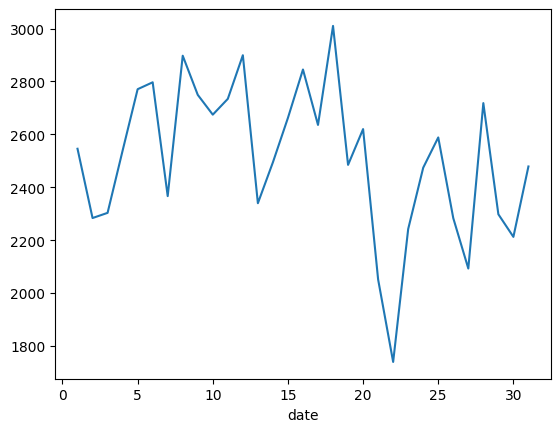

In [53]:
skai_articles_df['text'].str.len().groupby(by=skai_articles_df.index.day).mean().plot()

Εδώ έχουμε το πλήθος των άθρων ανά ημέρα

<Axes: ylabel='date'>

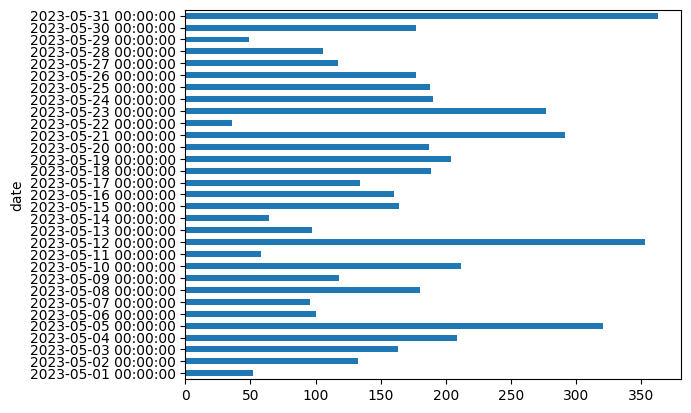

In [54]:
skai_articles_df['text'].resample('D').count().plot(kind='barh')

Εδώ βλέπουμε τη θετικόκτητα των άρθρων ανά ημέρα

<Axes: xlabel='date'>

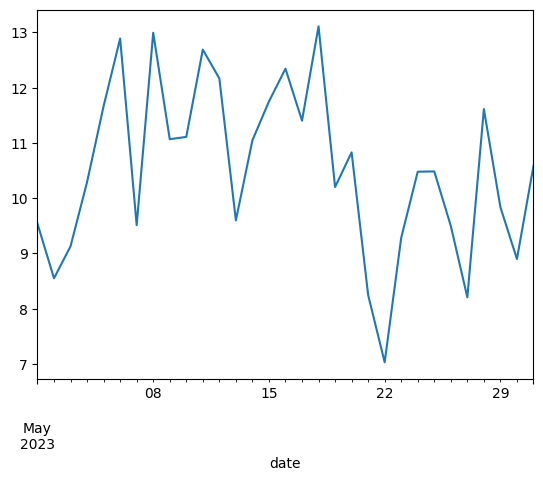

In [59]:
skai_articles_df['positive'].resample('D').mean().plot()

Και εδώ την αρνητικότητα

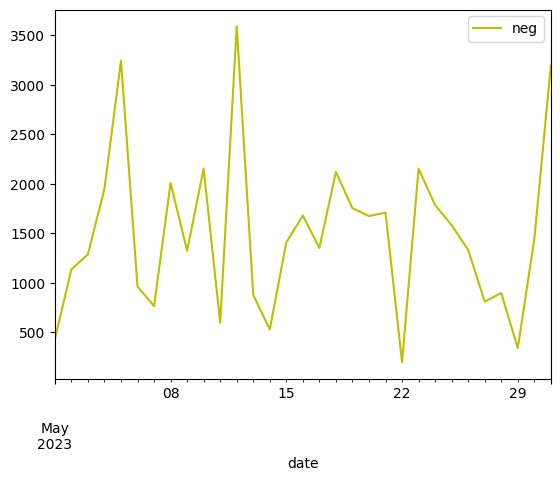

In [57]:
skai_articles_df['negative'].resample('D').sum().plot(color = 'y',label = 'neg').legend()

Προσπάθησα να βρω ποιο άθρθο έχει τη μεγαλύτερη θετικότητα και αρνητικότητα, ωστόσο μου βγάζει error όταν βάζω τις λεξεις "θετικότητα" και "αρνητικότητα" μαζί με τα πρόσημά τους. Γι' αυτό περιορίστηκα στα παραπάνω γραφήματα.